In [1]:
import numpy as np
import pandas as pd
from surprise import Reader, Dataset, prediction_algorithms, accuracy
from surprise.model_selection import cross_validate, train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import missingno as msno
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
books_df = pd.read_csv('./data/Books.csv', sep=",", low_memory=False)
users_df = pd.read_csv('./data/Users.csv', sep=",")
ratings_df = pd.read_csv('./data/Ratings.csv', sep=",")

In [3]:
rating_user = pd.merge(ratings_df, users_df, on='User-ID', how='left')
df = pd.merge(rating_user, books_df, on='ISBN', how='left')

<Axes: >

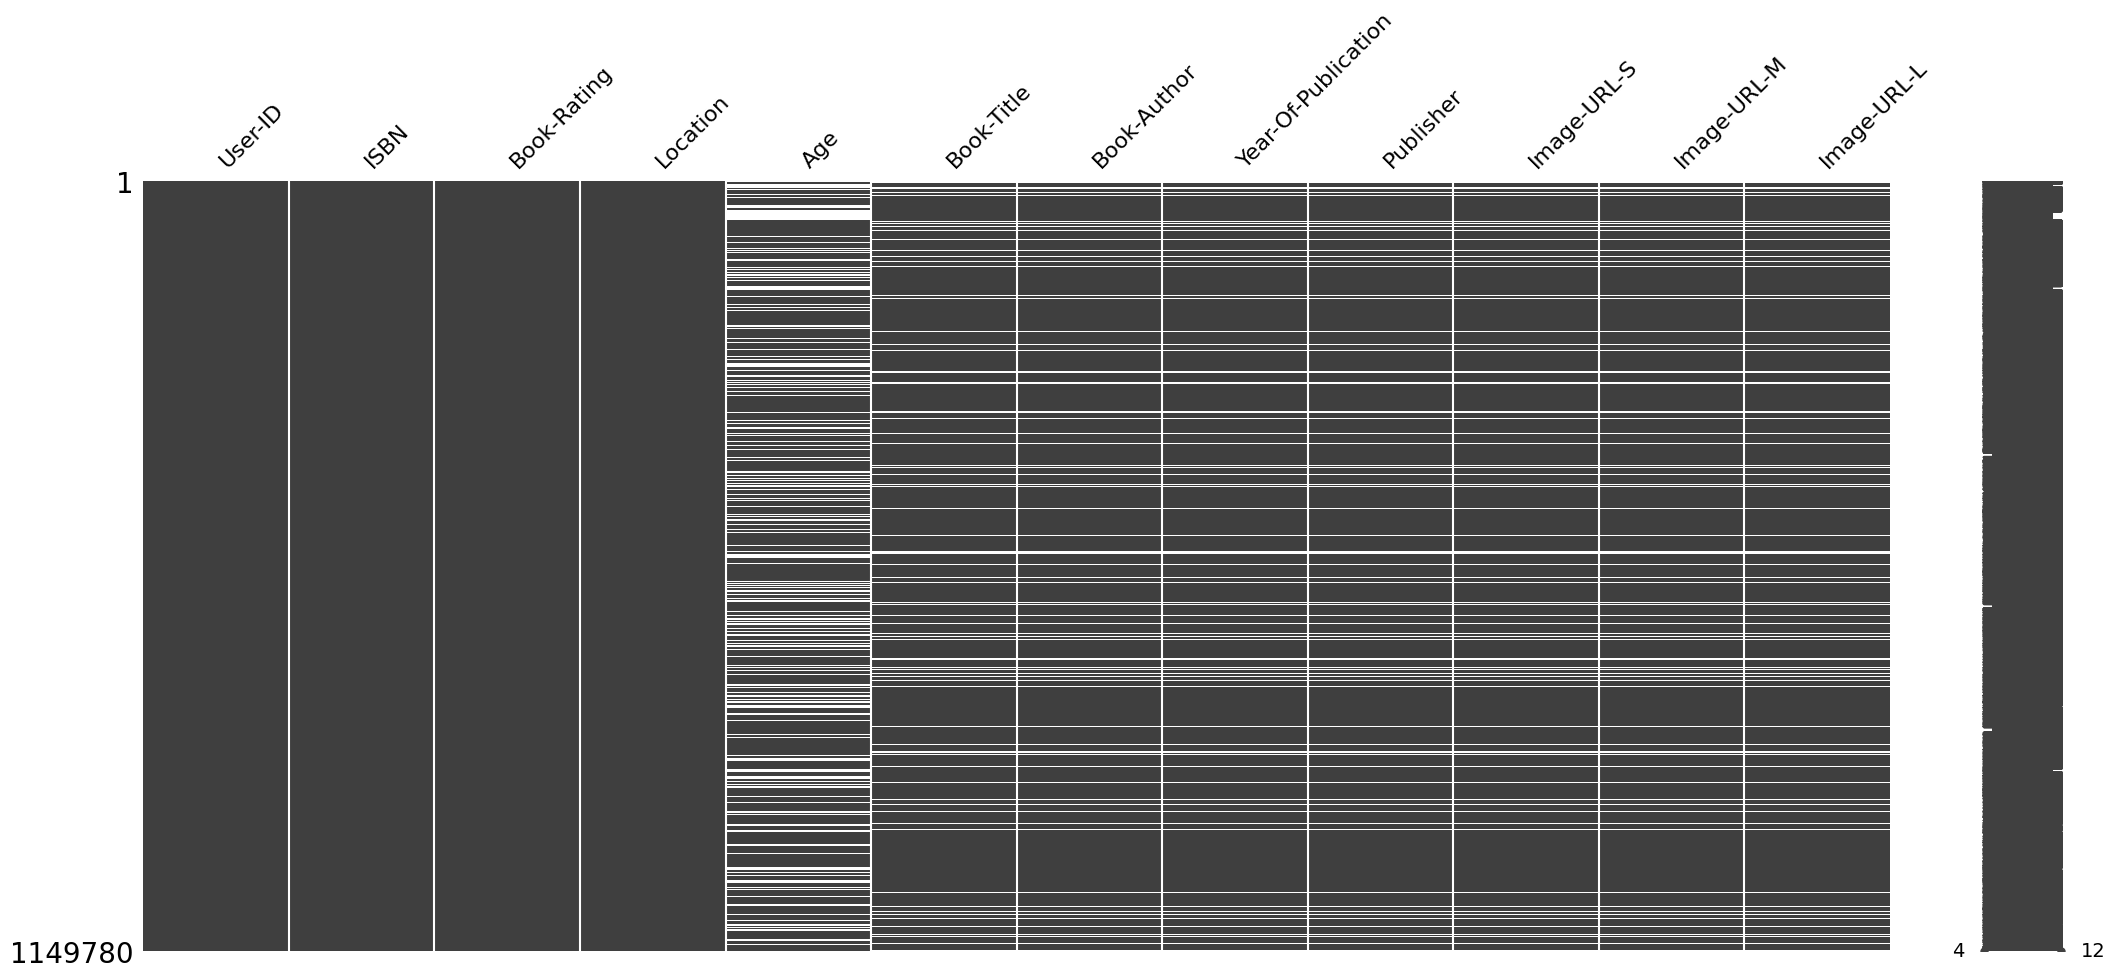

In [4]:
msno.matrix(df)

In [5]:
df = df.dropna()

<Axes: >

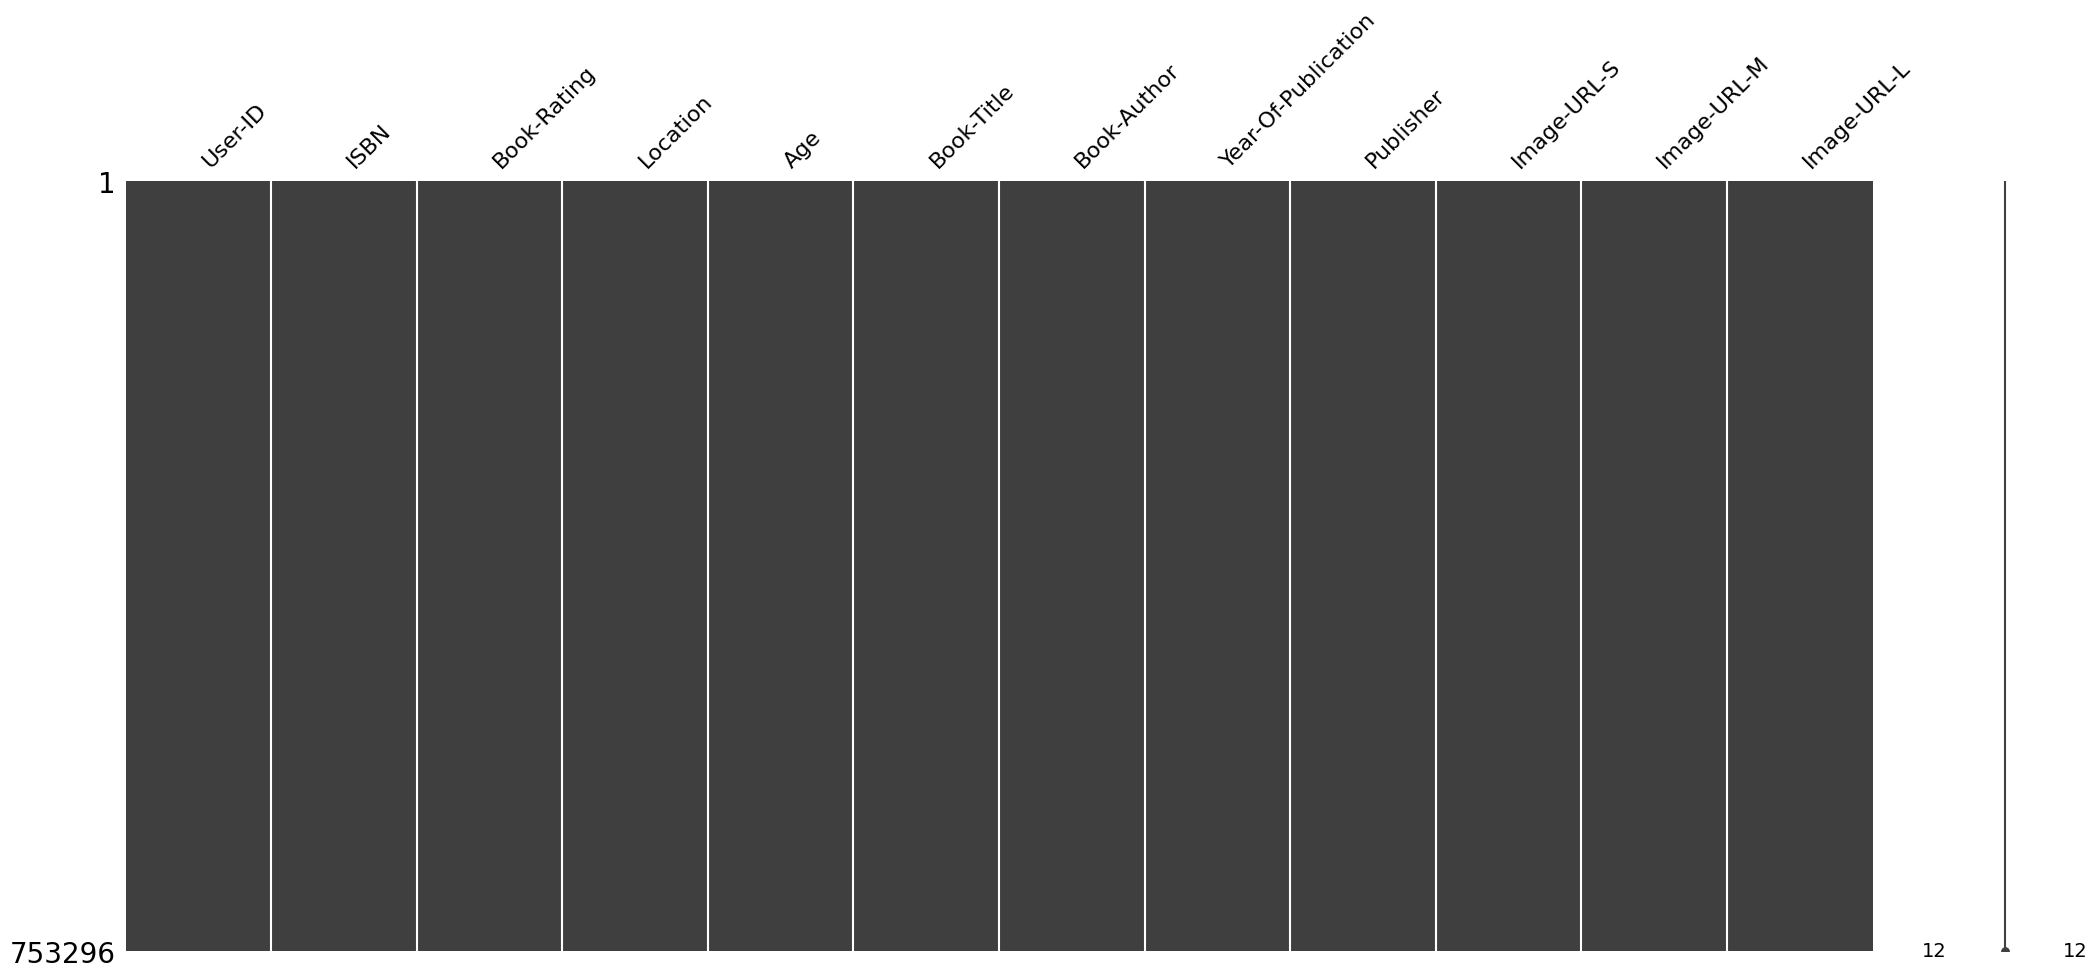

In [6]:
msno.matrix(df)

1. Crear un filtro colaborativo sencillo basado en memoria. Se puede elegir el que prefiera, item-to-item o user-to-user. Se 
puede realizar ajuste de hiper-parámetros intentando probar con diferentes variaciones de medida se similitud o forma 
de ponderar el valor estimado de los ratings. Este modelo nos debería servir como modelo base de partida.

In [7]:
sample_data = df.sample(frac=0.15, random_state=5)

reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(sample_data[['User-ID', 'ISBN', 'Book-Rating']], reader)
train, test = train_test_split(data, test_size=0.2)

# https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration
sim_options = \
    {
        'name': 'pearson_baseline',
        'user_based': True,
        'min_support': 5,
        'shrinkage': 50
    }

# https://surprise.readthedocs.io/en/stable/knn_inspired.html
user_to_user = prediction_algorithms.knns.KNNWithMeans(k=20, min_k=5, sim_options=sim_options, verbose=True)
user_to_user.fit(train)

results = cross_validate(user_to_user, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(f"Mean RMSE: {np.mean(results['test_rmse'])}")
print(f"Mean MAE: {np.mean(results['test_mae'])}")

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    3.7591  3.7595  3.7340  3.7507  3.7698  3.7546  0.0120  
MAE (testset)     3.1535  3.1534  3.1345  3.1528  3.1628  3.1514  0.0092  
Fit time  

In [8]:
user_id = 276822
book_isbn = '1551925060'

pred = user_to_user.predict(user_id, book_isbn, verbose=True)
print(f"Predicción de calificación para el usuario {user_id} y el libro {book_isbn}: {pred.est}")

user: 276822     item: 1551925060 r_ui = None   est = 2.74   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
Predicción de calificación para el usuario 276822 y el libro 1551925060: 2.7411611133235985


2. Crea una matriz de factorización construida mediante una red neuronal. Se puede hacer ajuste de hiper-parámetros 
para optimizar la métrica de salida. Elige la métrica y función de pérdida adecuada para entrenar esta red.

In [9]:
sample_data = df.sample(frac=0.1, random_state=5)

user_ids = sample_data["User-ID"].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

isbn_ids = sample_data['ISBN'].unique().tolist()
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_ids)}
isbn_encoded_to_isbn = {i: x for i, x in enumerate(isbn_ids)}

sample_data["user"] = sample_data['User-ID'].map(user_to_user_encoded)
sample_data["isbn"] = sample_data['ISBN'].map(isbn_to_isbn_encoded)

num_users = len(user_to_user_encoded)
num_isbns = len(isbn_to_isbn_encoded)

sample_data['Book-Rating'] = sample_data['Book-Rating'].values.astype(np.float32)

min_rating = min(sample_data["Book-Rating"])
max_rating = max(sample_data["Book-Rating"])

print(
    "Numero de usuarios: {}, Numero de libros: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_isbns, min_rating, max_rating
    )
)

x = sample_data[['user', 'isbn']].values
y = sample_data[['Book-Rating']].values

train_indices = int(0.9 * sample_data.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

sample_data

Numero de usuarios: 15983, Numero de libros: 47702, Min rating: 0.0, Max rating: 10.0


,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,user,isbn
124913,28632,0743456319,4.0,"vancouver, washington, usa",37.0,Fantasy Life,Kristine Kathryn Rusch,2003,Pocket Star,http://images.amazon.com/images/P/0743456319.0...,http://images.amazon.com/images/P/0743456319.0...,http://images.amazon.com/images/P/0743456319.0...,0,0
519145,125692,0671872001,5.0,"elmira, new york, usa",28.0,Disappearing Acts,Terry McMillan,1993,Pocket,http://images.amazon.com/images/P/0671872001.0...,http://images.amazon.com/images/P/0671872001.0...,http://images.amazon.com/images/P/0671872001.0...,1,1
940148,227520,0515118230,0.0,"san jose, california, usa",33.0,Home Song,Lavyrle Spencer,1995,Jove Books,http://images.amazon.com/images/P/0515118230.0...,http://images.amazon.com/images/P/0515118230.0...,http://images.amazon.com/images/P/0515118230.0...,2,2
557907,134467,1564772691,7.0,"mannheim, baden-württemberg,",35.0,Fat Quarter Quilts,Mliss Rae Hawley,1999,Martingale and Company,http://images.amazon.com/images/P/1564772691.0...,http://images.amazon.com/images/P/1564772691.0...,http://images.amazon.com/images/P/1564772691.0...,3,3
703943,171118,0156632772,8.0,"toronto, ontario, canada",47.0,Murder in the Cathedral (A Harvest/Hbj Book),T. S. Eliot,1964,Harvest Books,http://images.amazon.com/images/P/0156632772.0...,http://images.amazon.com/images/P/0156632772.0...,http://images.amazon.com/images/P/0156632772.0...,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411397,98391,1575667916,5.0,"morrow, georgia, usa",52.0,Second Chances,Marlene Fanta Shyer,2001,Kensington Publishing Corporation,http://images.amazon.com/images/P/1575667916.0...,http://images.amazon.com/images/P/1575667916.0...,http://images.amazon.com/images/P/1575667916.0...,118,15097
990622,238120,1577481097,0.0,"louisville, kentucky, usa",25.0,Snacks &amp; Appetizers: A Giving Christmas Id...,Not Applicable (Na ),1997,Barbour Pub Inc,http://images.amazon.com/images/P/1577481097.0...,http://images.amazon.com/images/P/1577481097.0...,http://images.amazon.com/images/P/1577481097.0...,1003,47699
487272,115905,0802772358,8.0,"toronto, ontario, canada",28.0,"The Year's Best Mystery and Suspense Stories, ...",Edward Hoch,1983,Walker &amp; Co,http://images.amazon.com/images/P/0802772358.0...,http://images.amazon.com/images/P/0802772358.0...,http://images.amazon.com/images/P/0802772358.0...,15982,47700
1102065,264525,1558746161,9.0,"quezon city, manila, philippines",17.0,Chicken Soup for the Teenage Soul II (Chicken ...,Jack Canfield,1998,HCI Teens,http://images.amazon.com/images/P/1558746161.0...,http://images.amazon.com/images/P/1558746161.0...,http://images.amazon.com/images/P/1558746161.0...,2276,8923


In [10]:
x_train[0]

array([0, 0], dtype=int64)

In [11]:
EMBEDDING_SIZE = 10

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_isbns, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_isbns = num_isbns
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.isbn_embedding = layers.Embedding(
            num_isbns,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.isbn_bias = layers.Embedding(num_isbns, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        isbn_vector = self.isbn_embedding(inputs[:, 1])
        isbn_bias = self.isbn_bias(inputs[:, 1])
        dot_user_isbn = tf.tensordot(user_vector,  isbn_vector, axes=2)

        x = dot_user_isbn + user_bias + isbn_bias

        return x
    
neural_network_model = RecommenderNet(num_users, num_isbns, EMBEDDING_SIZE)
neural_network_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

history = neural_network_model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 22.2385 - val_loss: 21.9325
Epoch 2/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 18.8530 - val_loss: 20.3704
Epoch 3/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 15.0993 - val_loss: 21.0775
Epoch 4/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 13.8777 - val_loss: 20.8125
Epoch 5/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 13.5624 - val_loss: 20.9569
Epoch 6/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 13.1710 - val_loss: 20.9332
Epoch 7/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 12.9153 - val_loss: 21.0112
Epoch 8/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 12.5782 - val_loss: 21.0753
Epoch 9/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 12.3257 - val_loss: 21.1476
Epoch 10/10
530/530 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 12.1771 - val_loss: 21.1442


In [12]:
user_id = 276727
book_isbn = '0590442449'

user_i = user_to_user_encoded[user_id]
isbn_i = isbn_to_isbn_encoded[book_isbn]

input_data = np.array([[user_i, isbn_i]])

# Realiza la predicción
predicted_rating = neural_network_model.predict(input_data)

# Imprime la predicción
print(f"Predicción de calificación para el usuario {user_id} y el libro {book_isbn}: {predicted_rating[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Predicción de calificación para el usuario 276727 y el libro 0590442449: -0.47017714381217957


3. Prueba a crear un recomendador basado en contenido y en perfil de cliente, sin hacer uso de filtros colaborativos. Utiliza 
también una red neuronal optimizada mediante hiper-parámetro. 

In [13]:
user_ids = df["User-ID"].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

isbn_ids = df['ISBN'].unique().tolist()
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_ids)}
isbn_encoded_to_isbn = {i: x for i, x in enumerate(isbn_ids)}

features = ['Book-Author', 'Publisher', 'Year-Of-Publication']
for feature in features:
    df[feature] = df[feature].astype('category').cat.codes

df["user"] = df['User-ID'].map(user_to_user_encoded)
df["isbn"] = df['ISBN'].map(isbn_to_isbn_encoded)

num_users = len(user_to_user_encoded)
num_isbns = len(isbn_to_isbn_encoded)

sample_data = df.sample(frac=0.1, random_state=5)
sample_data['Book-Rating'] = sample_data['Book-Rating'].values.astype(np.float32)

min_rating = min(sample_data["Book-Rating"])
max_rating = max(sample_data["Book-Rating"])

print(
    "Numero de usuarios: {}, Numero de libros: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_isbns, min_rating, max_rating
    )
)

x = sample_data[['user', 'isbn']].values
y = sample_data['Book-Rating'].values

train_indices = int(0.9 * sample_data.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

Numero de usuarios: 53887, Numero de libros: 228996, Min rating: 0.0, Max rating: 10.0


: 

In [14]:
EMBEDDING_SIZE = 10

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_isbns, num_features, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_isbns = num_isbns
        self.num_features = num_features
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.isbn_features = layers.Dense(
            64, activation='relu'
        )
        
        self.mixer1 = layers.Dense(64, activation='relu')
        self.mixer2 = layers.Dense(32, activation='relu')
        self.mixer3 = layers.Dense(1, activation='relu')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        isbn_vector = self.isbn_features(inputs[:, 2:])
        c = layers.Concatenate()([user_vector, isbn_vector])
        o1 = self.mixer1(c)
        o2 = self.mixer2(o1)
        o3 = self.mixer3(o2)
        return o3
    
recommendation_model = RecommenderNet(num_users, num_isbns, len(features), EMBEDDING_SIZE)
recommendation_model.compile(
    loss=tf.keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

history = recommendation_model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/10


In [ ]:
user_id = 276727
book_isbn = '0590442449'
books_read_by_user = df[df['User-ID'] == user_id]
books_not_readed = books_df[~books_df['ISBN'].isin(books_read_by_user['ISBN'].values)]['ISBN']
books_not_readed = list(set(books_not_readed).intersection(set(isbn_to_isbn_encoded.keys())))
books_not_readed = [[isbn_to_isbn_encoded.get(x)] for x in books_not_readed]
user_encoded = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(([[user_encoded]] * len(books_not_readed), books_not_readed))
user_id_ev = df[df['User-ID'] == user_id]
user_id_ev_b = user_id_ev[user_id_ev['ISBN'].isin(user_book_array[:,1].tolist())]
colums = ['user', 'isbn']
rating = recommendation_model.predict(user_id_ev_b[colums].values).flatten()

top_rating_indices = rating.argsort()[-10:][::-1]

recommended_books_ids = [isbn_encoded_to_isbn.get(books_not_readed[x][0]) for x in top_rating_indices]

print("Recomendaciones para el usuario:", user_id)
print("Libros con altas calificaciones del usuario")
top_books_user = (
    books_read_by_user.sort_values(by="Book-Rating", ascending=False)
    .head(5)
    .ISBN.values
)
book_df_rows = books_df[books_df["ISBN"].isin(top_books_user)]
for row in book_df_rows.itertuples():
    print(row.Book_Title)

print("Top 10 recomendaciones")
recommended_books = books_df[books_df["ISBN"].isin(recommended_books_ids)]
for row in recommended_books.itertuples():
    print(row.Book_Title)
